In [1]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import scipy.optimize
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy import interpolate

def generate_populations_dataset():
    SH = np.array([20,20,52,83,64,68,83,12,36,150,110,60,7,10,70,100,92,70,10,11,137,137,18,22,52,83,18,10,9,65])
    CL = np.array([32,50,12,10,13,36,15,12,6,6,65,70,40,9,20,34,45,40,15,15,60,80,26,18,37,50,35,12,12,25])

    X = np.zeros((len(SH),2))
    X[:,0] = SH
    X[:,1] = CL

    dt = 2
    t = np.arange(1845,1903+dt,dt) 

    # plot dataset
    plt.figure()
    plt.plot(t,SH, '-b')
    plt.plot(t,CL, '-r')

    plt.legend(("Snowshoe Hare","Canadian Lynx"), loc = 2)

    plt.ylabel('number of animals')
    plt.xlabel('years')
    plt.ylim((0,200))
    plt.grid()
    

    return X,t,dt


def interpolation(t ,X, t_new):
    #f_0 = interpolate.interp1d(t, X[:,0])
    #f_1 = interpolate.interp1d(t, X[:,1])

    f_0 = interpolate.splrep(t, X[:,0])
    f_1 = interpolate.splrep(t, X[:,1])

    X_new = np.zeros((len(t_new),2))
    #X_new[:,0] = f_0(t_new)
    #X_new[:,1] = f_1(t_new)

    X_new[:,0] = interpolate.splev(t_new, f_0)
    X_new[:,1] = interpolate.splev(t_new, f_1)

    return X_new


def sim(variables, t, params):

    # fish population level
    x = variables[0]

    # bear population level
    y = variables[1]


    alpha = params[0]
    beta = params[1]
    delta = params[2]
    gamma = params[3]

    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y

    return([dxdt, dydt])

def loss_function(params, years,fish_pop, bears_pop):

    y0 = [fish_pop[0], bears_pop[0]]
    t0 = 0
    t = np.linspace(years[0], years[-1], num=len(years))
    #output = odeint(sim, y0, t, rtol = r_tol, atol = a_tol , hmax = hmax , hmin = hmin ,args=(params,))
    output = solve_ivp( sim , ([t0,t[-1]]), y0,  t_eval=t,method='RK45', rtol = r_tol, atol = a_tol ,dense_output=True,args=(params,))
    
    loss = 0

    for i in range(len(years)):
        data_fish = fish_pop[i]
        model_fish = output[i,0]
        data_bears = bears_pop[i]
        model_bears = output[i,1]
        res = (data_fish - model_fish)**2 + (data_bears - model_bears)**2

        loss += res

    return(loss)



[0.70821343 0.31425853 0.33036111 0.68215272]


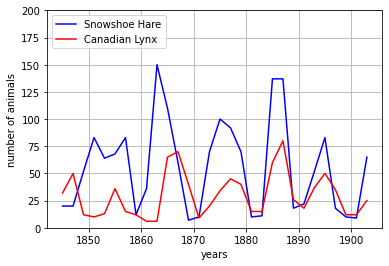

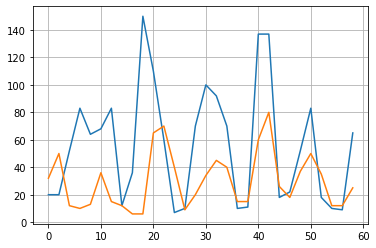

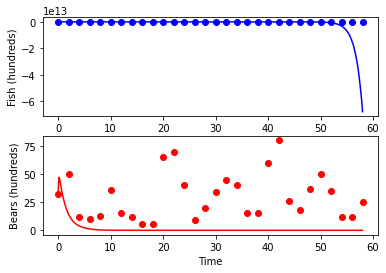

In [3]:
X,t,dt = generate_populations_dataset()
t = np.arange(0,60,dt)

interpolation_active = False

if interpolation_active == True:
    dt_new = 0.01
    t_new = np.arange(t[0],t[-1],dt_new)
    X_new = interpolation(t ,X, t_new)
    print(len(t_new))
    t = t_new
    X = X_new
    dt = dt_new


plt.figure()
plt.plot(t,X[:,0])
plt.plot(t,X[:,1])
plt.grid()

years = t.tolist()

fish_pop = X[:,0].tolist()
bears_pop = X[:,1].tolist()

f,(ax1,ax2) = plt.subplots(2)

line1 = ax1.scatter(years,fish_pop, c="b")
line2 = ax2.scatter(years,bears_pop, c="r")

ax1.set_ylabel("Fish (hundreds)")
ax2.set_ylabel("Bears (hundreds)")
ax2.set_xlabel("Time")

# ode int settings
r_tol = 1e-1
a_tol = 1e-2
hmax = 1e10
hmin = 1e-2


# initial guess
params0_alpha = 2/3
params0_beta = 1/3
params0_gamma = 1/3
params0_delta = 2/3

params0 = np.array([params0_alpha, params0_beta, params0_gamma, params0_delta])

#minimum = scipy.optimize.fmin(loss_function, params0, args=(years,fish_pop, bears_pop))
minimum = curve_fit(loss_function,t,params0, args=(years,fish_pop, bears_pop))

print(minimum)

alpha_fit = minimum[0]
beta_fit = minimum[1]
delta_fit = minimum[2]
gamma_fit = minimum[3]

params = [alpha_fit, beta_fit, delta_fit, gamma_fit]

y0 = [fish_pop[0], bears_pop[0]]


t = np.linspace(years[0], years[-1], num=int(1e3))
t0 = 0

output = odeint(sim, y0, t, rtol = r_tol, atol = a_tol , hmax = hmax , hmin = hmin ,args=(params,))
#output = solve_ivp( sim , ([t0,t[-1]]), y0,  t_eval=t,method='RK45', rtol = r_tol, atol = a_tol ,dense_output=True,args=(params,))

line1, = ax1.plot(t,output[:,0], color="b")
line2, = ax2.plot(t,output[:,1], color="r")

ax1.set_ylabel("Fish (hundreds)")
ax2.set_ylabel("Bears (hundreds)")
ax2.set_xlabel("Time")

plt.show()
